# Cuff_Less Blood Pressure Estimation:

**Overview:**

<em style='color: red'>Blood pressure (BP)</em>, also referred to as <em style='color: red'>Arterial blood pressure (ABP)</em>, is the pressure exerted by circulating blood upon the walls of blood vessels.


The most common approach to measure Blood Pressure (BP) without clinical supervision is the automated BP cuff employing oscillometry. A cuff is wrapped around the upper arm and inflated above systolic pressure, then deflated to a pressure below diastolic BP. A pressure sensor inserted in the cuff records the arterial pulsations during the cuff deflation, and the amplitudes of these pulsations are used to calculate systolic and diastolic BP. 

<div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Blood_pressure_monitoring.jpg/1920px-Blood_pressure_monitoring.jpg", height="100", width="500"/></div>


This approach has many limitations, the primary one being that it relies on a set of empirical coefficients to map the pulse amplitudes to systolic and diastolic BP. Most of these coefficients are specific to the device and can vary across devices. 

Further, since it relies solely on pulse amplitudes, <strong> it fails to provide accurate readings in patients with atherosclerosis or obese patients whose pulse amplitudes can be weak</strong>.

**ElectroCardiogram (ECG)**

ECG or EKG check for signs of heart disease. It's a test that records the electrical activity of your ticker through small electrode patches that a technician attaches to the skin of your chest, arms, and legs.

An abnormal ECG can tell your doctor if you have any of these issues:


1.   irregular heartbeat (an arrhythmia)
2.   problems with the spread of electrical activity within the heart
3.   an enlarged heart
4.   areas of the heart with reduced blood supply
5.   a ‘silent’ heart attack (an interruption to blood flow in the     coronary arteries without usual heart attack symptoms).


<div><img src="https://ecglibrary.com/ecgs/norm_2x.png", height="100", width="500"/></div>

**PhotoPlethysmoGraph (PPG)**

A photoplethysmogram (PPG) is an optically obtained plethysmogram that can be used to detect blood volume changes in the microvascular bed of tissue. A PPG is often obtained by using a pulse oximeter which illuminates the skin and measures changes in light absorption.A conventional pulse oximeter monitors the perfusion of blood to the dermis and subcutaneous tissue of the skin.

A plethysmograph is an instrument for measuring changes in volume within an organ or whole body (usually resulting from fluctuations in the amount of blood or air it contains). 

<div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Pulse_oximiter%2C_Photoplethysmograph.jpg/675px-Pulse_oximiter%2C_Photoplethysmograph.jpg", height="50", width="300"/></div>

**The dataset:**

The blood pressure dataset provides clean and valid signals for designing cuff-less blood pressure estimation algorithms. 
The matlab files (.mat) contain raw electrocardiogram (ECG), photoplethysmograph (PPG), and arterial blood pressure (ABP) signals stored as [cell arrays](https://www.mathworks.com/help/matlab/ref/cell.html#:~:text=A%20cell%20array%20is%20a,indices%20in%20smooth%20parentheses%2C%20()%20.) of matrices where each cell is one record part. 
In each matrix, each row corresponds to one signal channel: 

1: PPG signal, FS=125Hz; photoplethysmograph from fingertip 

2: ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg) 

3: ECG signal, FS=125Hz; electrocardiogram from channel II 

Note: Each cell is a record. There might be more than one record per patient (which is not possible to distinguish). However, records of the same patient appear next to each other. 
n-fold cross test and train is suggested to reduce the chance of train set being contaminated by test patients

## Data Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')   # to avoid warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import math
from scipy import io
sns.set(style="darkgrid")

ModuleNotFoundError: No module named 'seaborn'

In [80]:
# defining our evaluation error function
def rmse(y_true, y_pred):
    """Computes the Root Mean Squared Error (RMSE)."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [81]:
sample_file = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')
print(f'sample_file Data type: {type(sample_file)}')
print(f'sample_file keys:\n{sample_file.keys()}')


sample_file Data type: <class 'dict'>
sample_file keys:
dict_keys(['__header__', '__version__', '__globals__', 'p'])


What's happening in the cell above?

* We use the `scipy.io.loadmat()` method to read our sample matlab(.mat) file and store it in the variable `sample_file`
    * The `scipy.io.loadmat()` method reads the matlab file and returns a `dict`/(dictionary) which is then stored back in the `sample_file` variable. To prove this, we print the data type of sample_file `type(sample_file)` as seen in line-2 and bingo it tells us its a `dict`
    
* A [dictionary](https://realpython.com/python-dicts/) is a [data structure](https://en.wikipedia.org/wiki/Data_structure#:~:text=In%20computer%20science%2C%20a%20data,be%20applied%20to%20the%20data.) that stores data in key, value pairs. For instance; {key1: value1, key2: value2}. What line-3 in the cell above does is to get and return the keys of the `sample_file` dictionary.

* Things to try out:
    * try displaying all contents of the `sample file` dictionary to see all its data (hint: just type sample file below the last print statement)
    * display only the values of the `sample file` dictionary (hint: replace `.keys() with .values()`)
    * load any other matlab file by substituting the value 1 with any other in the range (1-12) as there are only 12 files provided.

From  what we've seen above, we only need the values contained in the key `p` (photoplethysmograph or (PPG)). The other keys contain meta data that we won't need.
Therefore in all other cells I'll apply `['p']` at the end of the `.loadmat() method` to only read the values contained in the key `['p']`i.e `scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')['p']`

In [82]:
# Loading a sample .mat file to understand the data dimensions
test_sample = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')['p']
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


In [83]:
## Try printing out the entire array to see its data.


So here's what's happening in the cell above:

* We use the `scipy.io.loadmat()` method to read our sample matlab(.mat) file and store it in the variable `test_sample`
    * The `scipy.io.loadmat()` method reads the matlab file and this time around returns a [numpy ndarray](https://numpy.org/doc/stable/reference/arrays.ndarray.html#:~:text=Quick%20search-,The%20N%2Ddimensional%20array%20(%20ndarray%20),the%20sizes%20of%20each%20dimension.) (because of the `['p']`)  which is then stored in the `test_sample` variable. To prove this, we print the data type of test_sample `type(test_sample)` as seen in line-2 and bingo it tells us its `numpy.ndarray` (nd means n-dimensional)
* Additionally, we check and print the size/dimensions of `test_sample` by running `test_sample.shape` and it prints out `(1,1000)`; <strong> this means the array contains 1 row and 1000 columns.</strong>

Things to try out:

* Load any other matlab file by substituting the value 1 with any other in the range (1-12) and re-run the cell (there are only 12 files provided.). You should get the same shape `(1,1000)`

* Print out the entire `test_sample` array and see what it contains. (Hint: use print(test_sample) or just type test_sample and run the cell). You should see an outer array and multiple inner arrays.i.e all files contain one row and 1000 columns where each column is itself an array.

* Try finding out the contents of each column and the size of each column (hint: accessing nested arrays)

In [84]:
print(f"Total Samples: {len(test_sample[0])}")
print(f"Number of readings in each sample(column): {len(test_sample[0][0])}")
print(f"Number of samples in each reading(ECG): {len(test_sample[0][0][2])}")

temp_mat = test_sample[0, 999]
temp_length = temp_mat.shape[1]
sample_size = 125


print(temp_length)
print((int)(temp_length/sample_size))

Total Samples: 1000
Number of readings in each sample(column): 3
Number of samples in each reading(ECG): 61000
9000
72


In [85]:
sample_size = 125
ppg = []
for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ppg = temp_mat[0, j*sample_size:(j+1)*sample_size]
        ppg.append(temp_ppg)

<a id='sbp_cell'></a>
In the cell below, I extract BP and ECG signals from the mat file and store them in an array/list.
* I additionally extract Systolic blood pressure(SBP) and Diastolic Blood pressure(DBP) from the BP signal.

* `systole` and `diastole` are two phases of a heart beat. `BP` <strong>increases</strong> as the heart muscle contracts during `systole`, where blood is pushed towards the periphery of the body and it <strong>decreases</strong> when the heart relaxes to fill with blood during the `diastole`. Hence we take `max(BP)` to derive `SBP` and `min(BP)` to get `DBP`. refer to [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6696196/) for more insight.

In [86]:
ecg = []
bp = []
sbp = [] #Systolic Blood Pressure
dbp = [] #Diastolic Blood Pressue
size = 125 #sample size

for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ecg = temp_mat[2, j*size:(j+1)*size]
        temp_bp = temp_mat[1, j*size:(j+1)*size]
        
        max_value = max(temp_bp)
        min_value = min(temp_bp)
        
        sbp.append(max_value)
        dbp.append(min_value)
        ecg.append(temp_ecg)
        bp.append(temp_bp)

In [87]:
# Reshaping the ecg, ppg and bp signal data into column vectors
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (32061000, 1)
 ECG_shape: (32061000, 1)
 BP_shape: (32061000, 1)
Systolic-BP_shape: (256488, 1),
 Diastolic-BP_shape: (256488, 1)


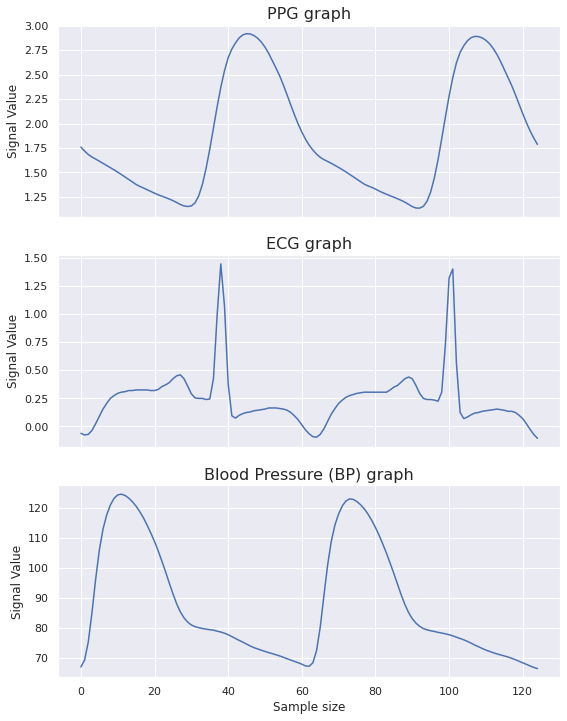

In [88]:
##plotting sample ppg, ecg and bp signals
##using a sample size of 125
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:125])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:125])

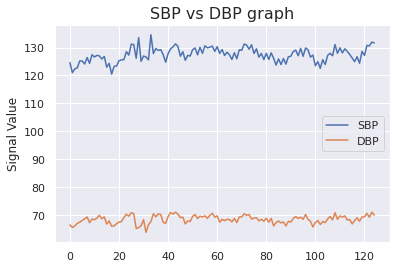

In [89]:
## Visualizing SBP and DBP
#fig, ax = plt.subplots(1,1, figsize=(9,12))

plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])

It can be seen from above that `SBP` is higher than `DBP` as was explained [earlier](#sbp_cell)

### Statistical Correlation of signals


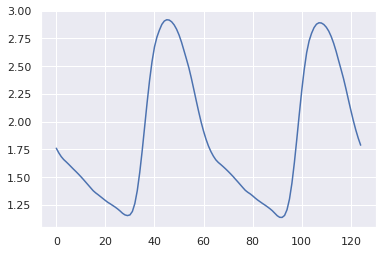

In [90]:
plt.plot(ppg[:125].squeeze())

### Computing and Visualizing the Cross correlation of PPG and BP signals

[Cross correlation](https://en.wikipedia.org/wiki/Cross-correlation#:~:text=In%20signal%20processing%2C%20cross%2Dcorrelation,for%20a%20shorter%2C%20known%20feature.) is where two signals are compared inorder to produce a third signal that shows the similarity between the two signals compared. It can be used to create plots that may reveal hidden sequences.

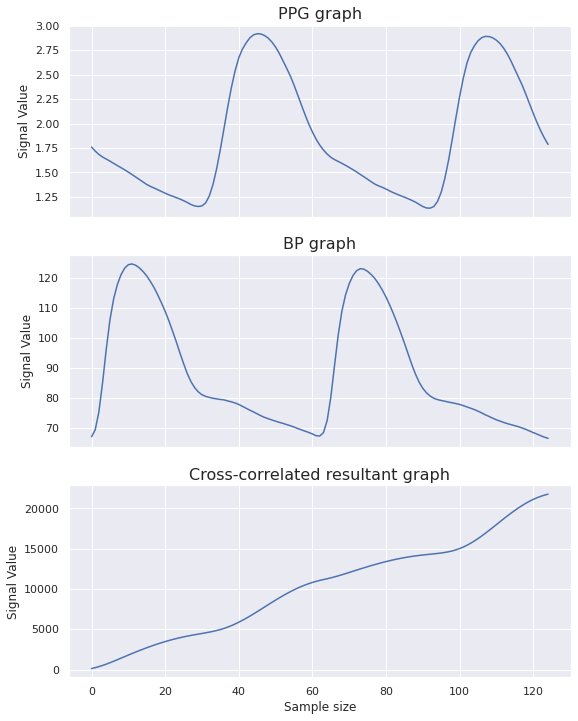

In [91]:
# Computing the cross correlation of ppg and bp signals
cross_corr = np.convolve(ppg[:125].squeeze(), bp[:125].squeeze(), mode='full')

fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('BP graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(bp[:125])

ax[2].set_title('Cross-correlated resultant graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(cross_corr[:125])

### Are PPG signals Discrete Cosine Transform (DCT) of BP signals

Lets assume that `BP` is `dct(PPG)` or that `BP` is a discrete cosine transform of PPG and try to prove this hypothesis using the root mean squared error as our evaluation function.

In [92]:
#Computing the discrete cosine transform (DCT)
cosine_transformed_array = dct(ecg)
error = rmse(ppg.squeeze(), cosine_transformed_array.squeeze())
print(f'RMSE: {error}')

RMSE: 1.9630059449503936


In [93]:
ppgDf = pd.DataFrame(ppg)
ecgDf = pd.DataFrame(ecg)
sbpDf = pd.DataFrame(sbp)
dbpDf = pd.DataFrame(dbp)


df = pd.concat([ppgDf, ecgDf, sbpDf, dbpDf], axis=1)
df.columns = ['PPG', 'ECG', 'SBP', 'DBP']
df.head()

,PPG,ECG,SBP,DBP
0,1.759531,-0.060606,124.601310,66.525670
1,1.718475,-0.075269,120.986846,65.597632
2,1.684262,-0.070381,122.354481,66.134917
3,1.657869,-0.035191,122.745234,67.062955
4,1.637341,0.024438,125.187439,67.502552


In [94]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PPG,32061000.0,1.687430,0.686861,0.000000,1.154448,1.504399,2.225806,4.001955
ECG,32061000.0,0.132839,0.590013,-3.498047,-0.141304,0.265137,0.504888,4.500000
SBP,256488.0,140.675999,22.042001,60.429867,124.698998,141.940967,157.082486,199.909345
DBP,256488.0,65.172295,11.038911,50.016239,57.381998,62.569298,70.394054,190.296816


## Skewnesss

Skewness is a way of estimating and measuring the shape of a distribution.

- A positive skew will indicate that the tail is on the right side. It will extend toward the most positive values.
- A negative skew will indicate a tail on the left side and will extend to the more negative side.
- A zero value will indicate that there is no skewness in the distribution, which means that the distribution is perfectly symmetrical.

In [95]:
df.columns

Index(['PPG', 'ECG', 'SBP', 'DBP'], dtype='object')

In [96]:
df.skew()

PPG    0.418069
ECG   -0.182836
SBP   -0.149745
DBP    1.779923
dtype: float64

## Kurtosis

Kurtosis is a statistical term that characterizes frequency distribution. Aside from determining if a distribution is heavy-tailed, it also provides insight into the shape of the frequency distribution.

- kurtosis for normal distribution is equal to 3.
- For a distribution having kurtosis < 3: It is called playkurtic.
- For a distribution having kurtosis > 3, It is called leptokurtic and it signifies that it tries to produce more outliers rather than the normal distribution.

In [97]:
df.kurtosis()

PPG   -0.704727
ECG    0.133224
SBP   -0.439482
DBP    5.788435
dtype: float64

# Univariate Analysis

## Visualizing features(scatter and line plot)

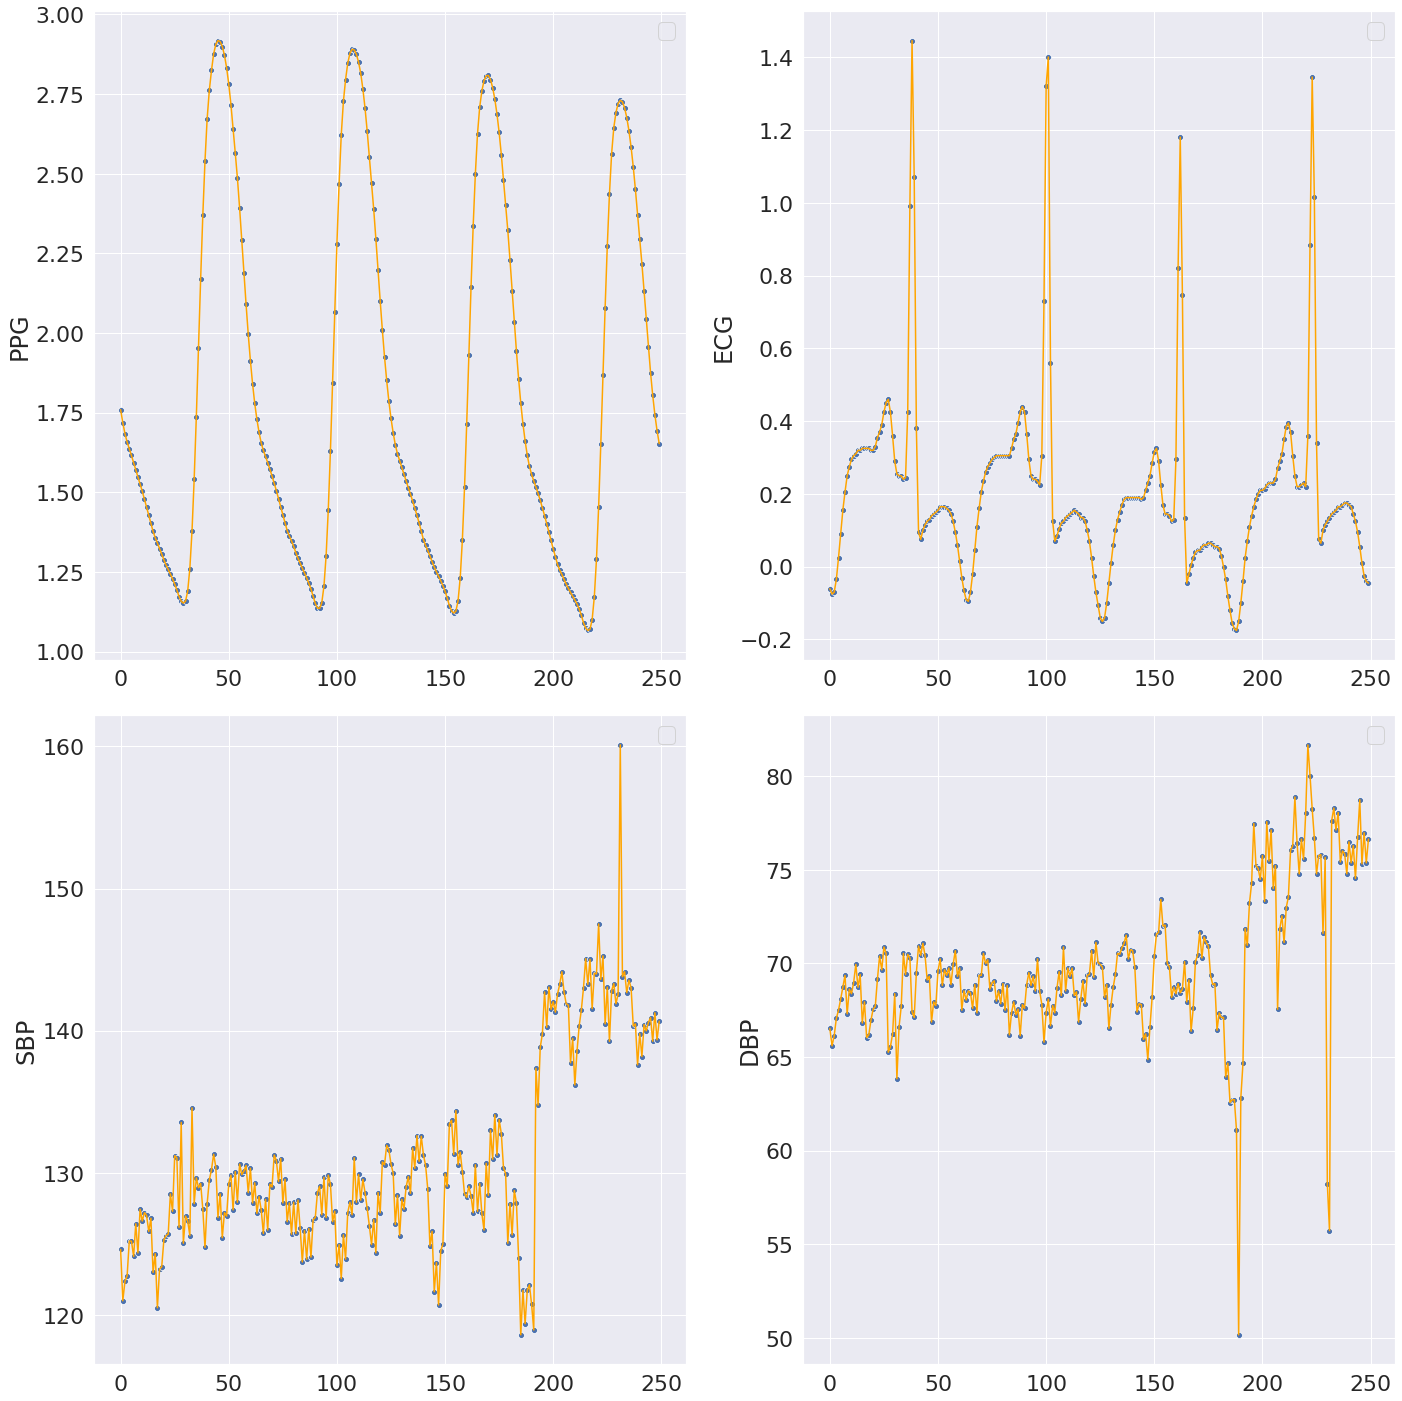

In [101]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)# Assuming df is your DataFrame

# Store the list of columns
columns_to_plot = df.columns
total_features_num = len(columns_to_plot)
subplot_cols = 2
subplot_rows = math.ceil(total_features_num / subplot_cols)

fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 20))

for i in range(0, total_features_num):
    row = math.floor(i/subplot_cols)
    col = i % subplot_cols
    column_name = df.columns[i]
    
    # Scatter plot
    sns.scatterplot(ax=axes[row, col], x=df.index[:250], y=df[column_name][:250])
    
    # Line plot
    sns.lineplot(ax=axes[row, col], x=df.index[:250], y=df[column_name][:250], color='orange')
    
    axes[row, col].legend()  # Show legend
    
# Adjust layout
plt.tight_layout() 
plt.show()


## Boxplots of all features

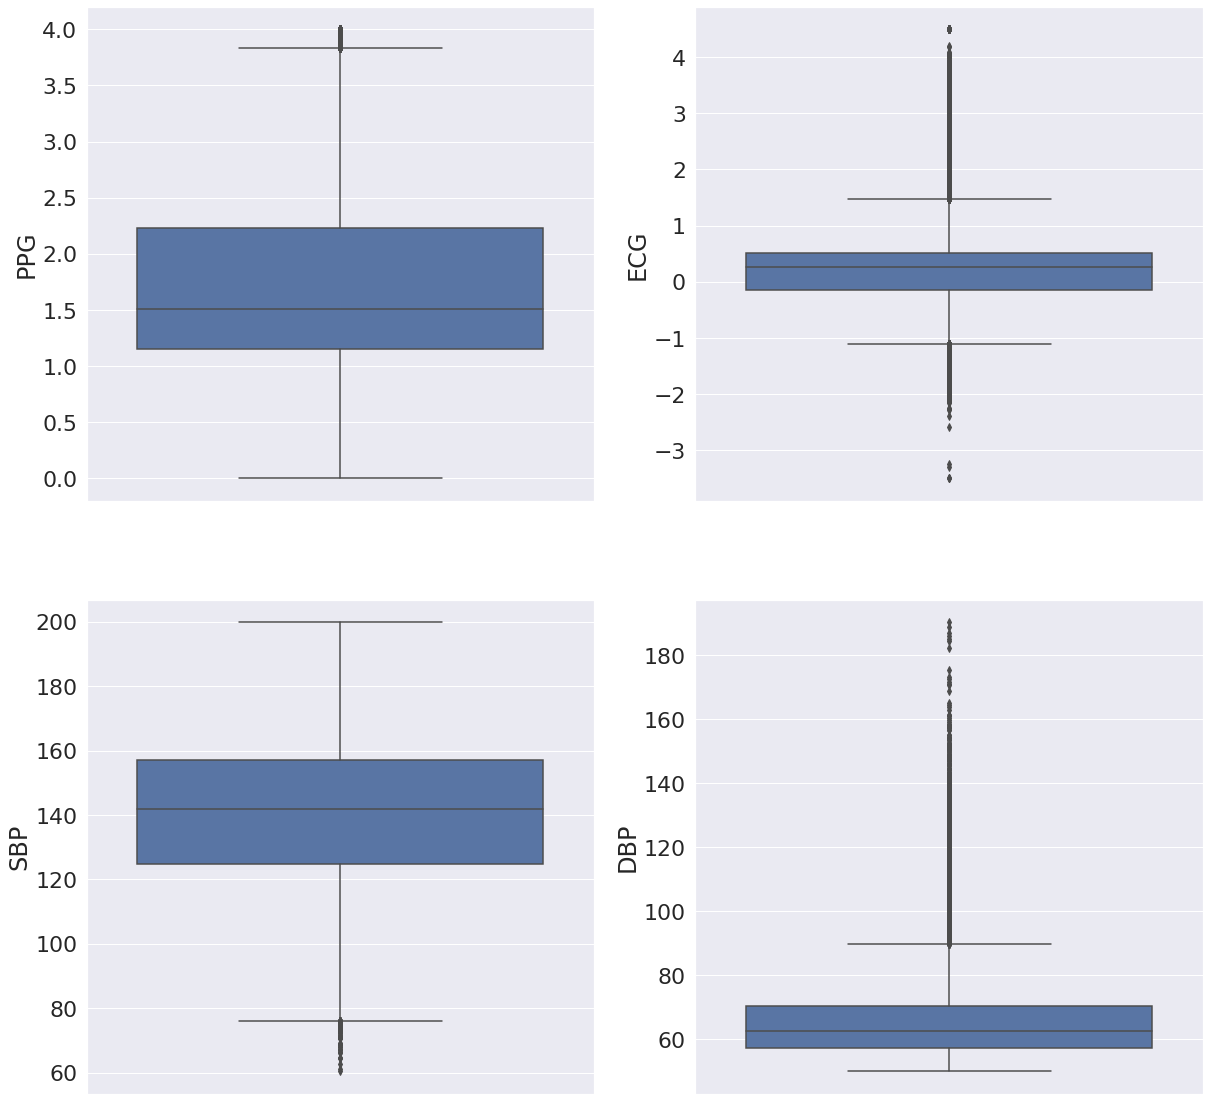

In [102]:
fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 20))

for i in range(0, total_features_num):
    row = math.floor(i/subplot_cols)
    col = i % subplot_cols
    sns.boxplot(ax=axes[row, col], y=df[df.columns[i]])
    
# Show the plot
# plt.tight_layout() 
plt.show()

## Histograms of all features 

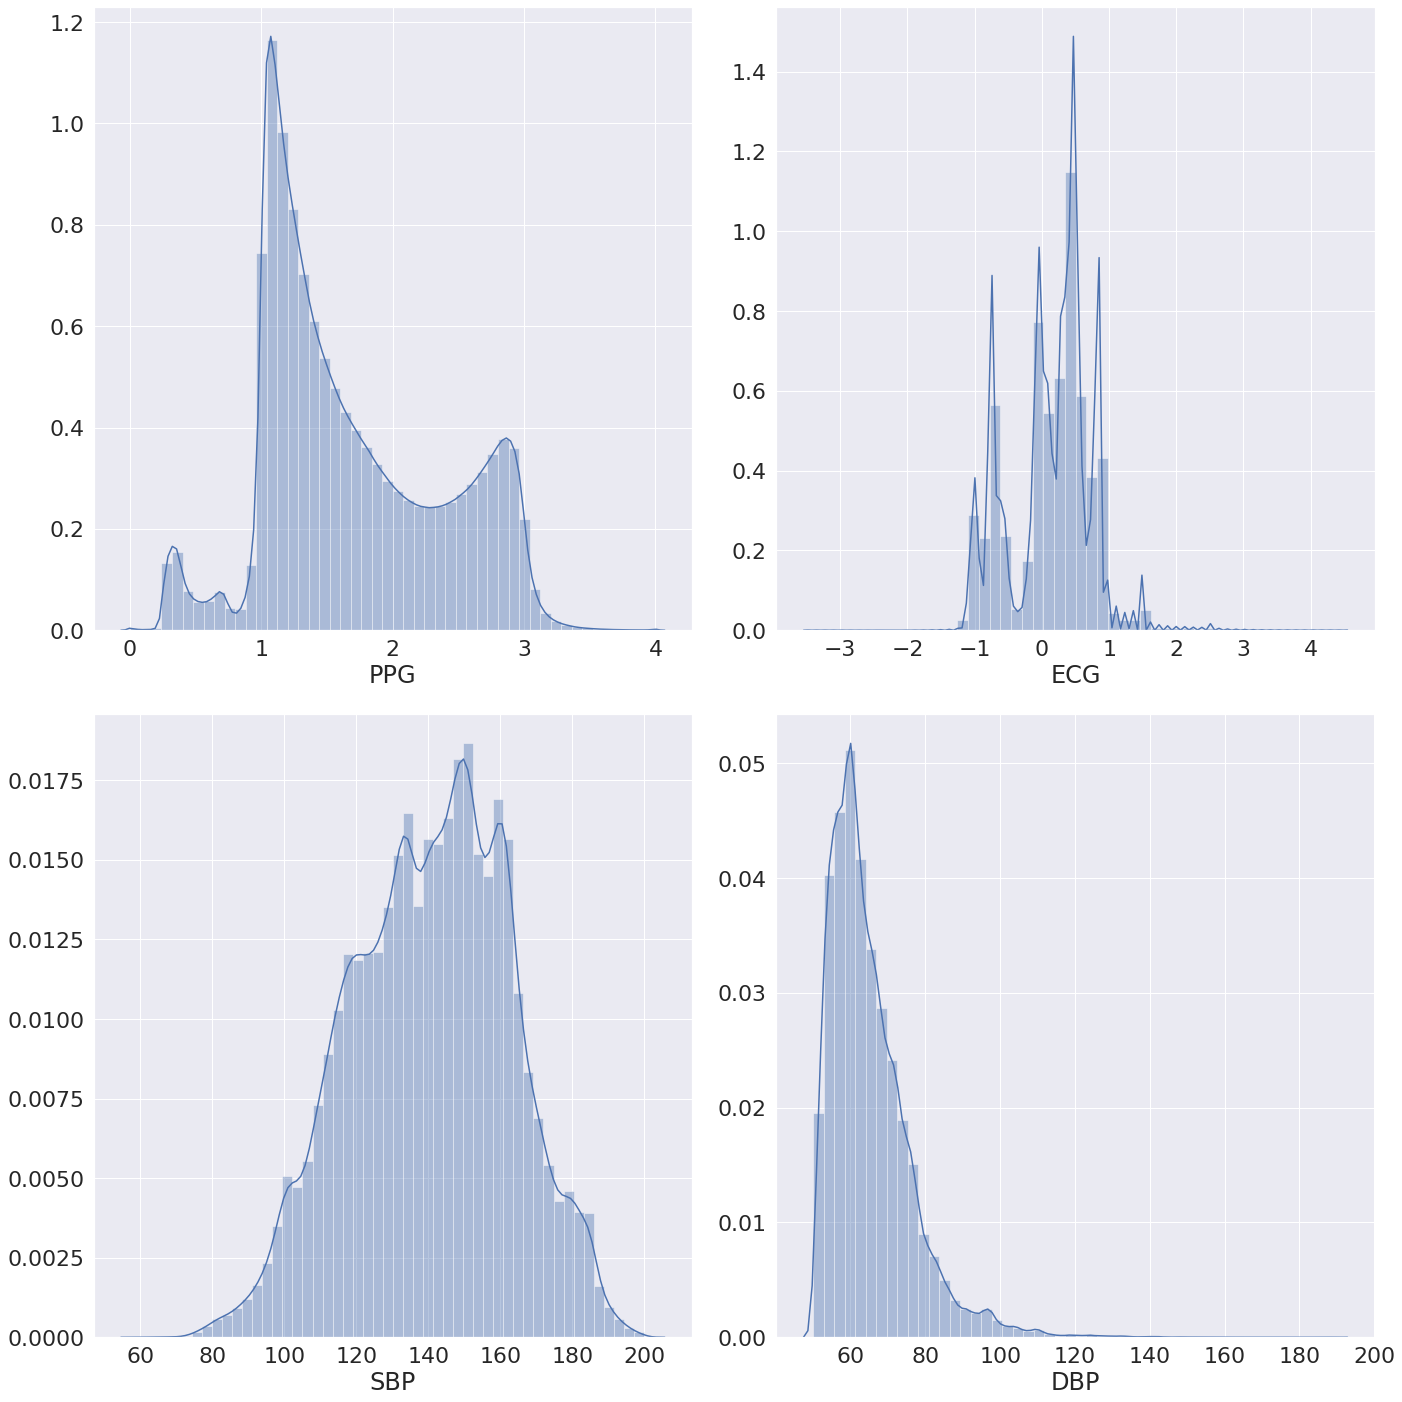

In [103]:
fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 20))

for i in range(0, total_features_num):
    row = math.floor(i/subplot_cols)
    col = i % subplot_cols
    sns.distplot(df[df.columns[i]], ax=axes[row, col], kde=True)
    
# Show the plot
plt.tight_layout() 
plt.show()

## Q-Q plots of all features
Linear models assume that the independent variables are normally distributed. Failure to meet this assumption may produce algorithms that perform poorly. We can determine whether a variable is normally distributed with histograms and Q-Q plots (short for “quantile-quantile” plots).

A Q-Q plot, is used to assess whether or not a set of data potentially came from some theoretical distribution.

We used it below to check whether or not (each of) our data feature follows a normal distribution.

In a Q-Q plot, the quantiles of the features are plotted against the expected quantiles of the normal distribution. If the variable is normally distributed, the dots in the Q-Q plot should fall along a 45 degree diagonal line (i.e., a straight diagonal line).

Conversely, the more the points in the plot deviate significantly from a straight diagonal line, the less likely the data (feature) follows a normal distribution.

In [104]:
# Install seaborn-qqplot library
!pip install seaborn-qqplot

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


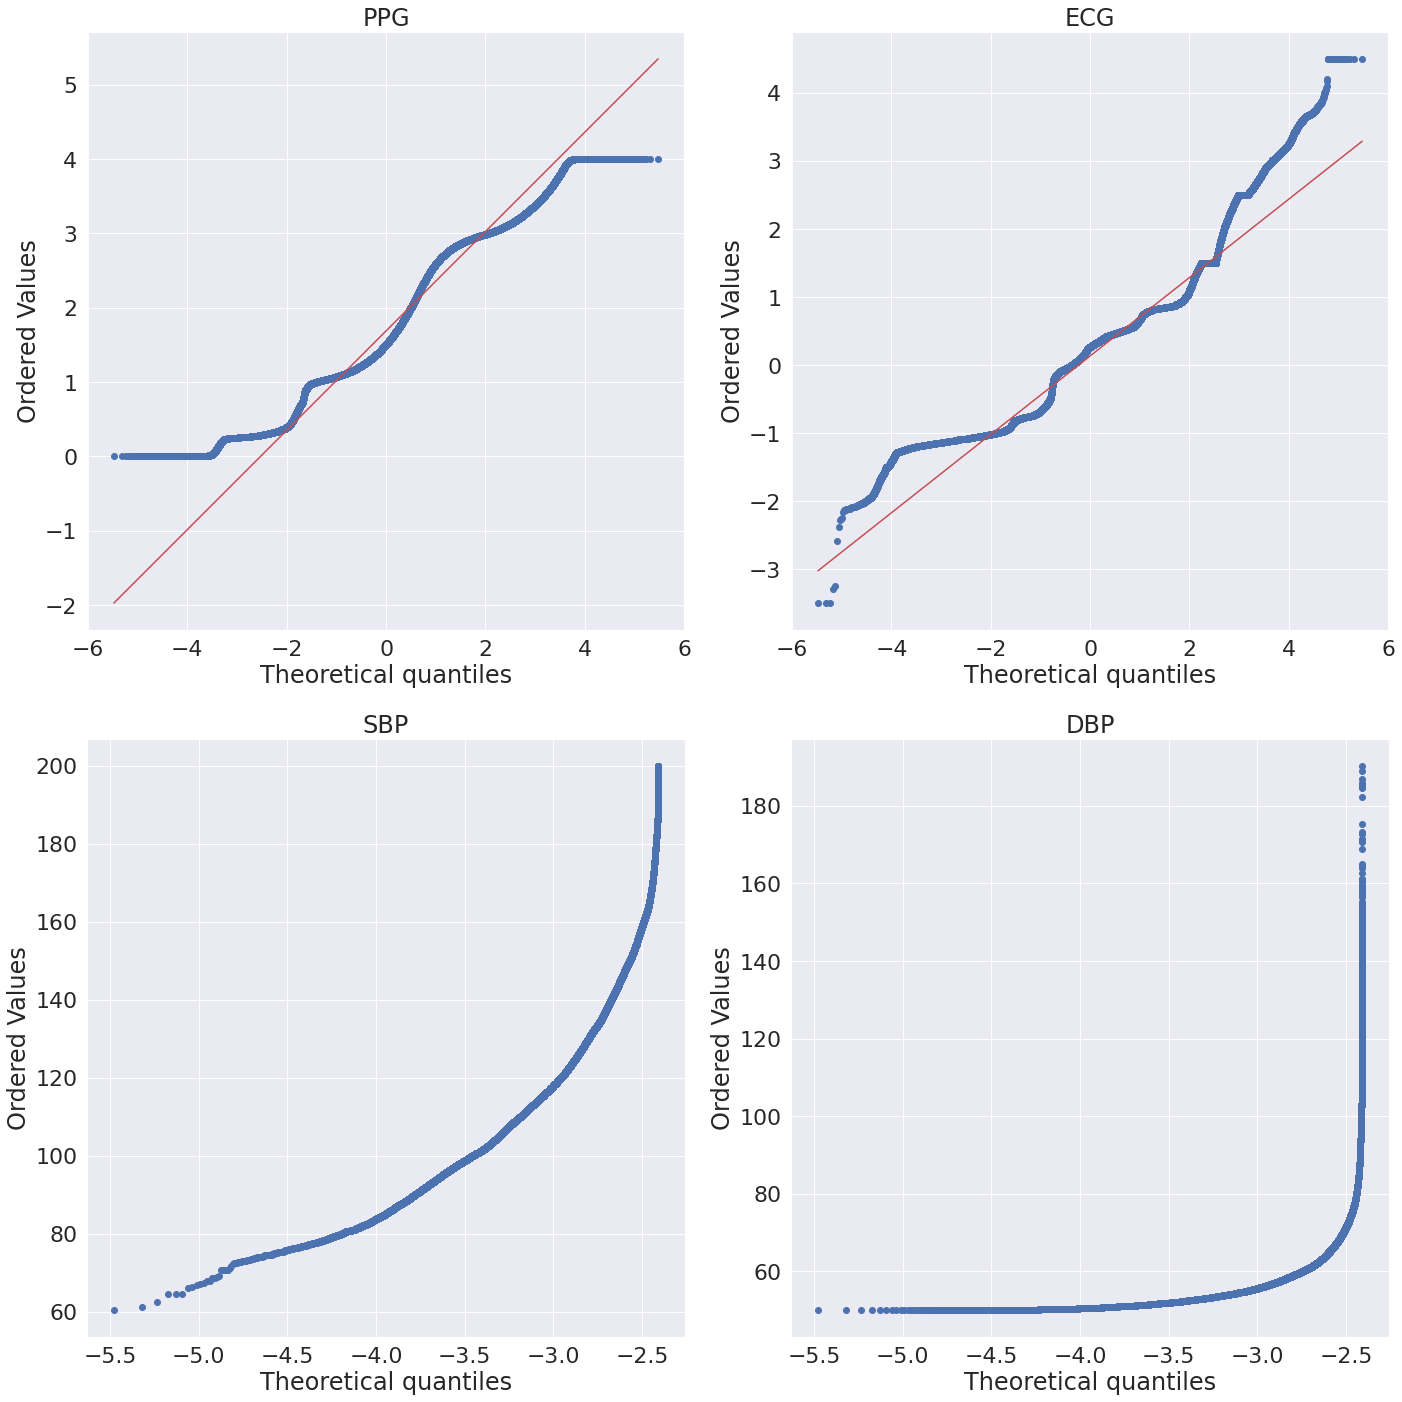

In [105]:
# QQ Plot
import scipy.stats as stats

fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(20, 20))

for i in range(0, total_features_num):
    row = math.floor(i/subplot_cols)
    col = i % subplot_cols
    col_name = df.columns[i]
    stats.probplot(df[col_name], dist="norm", plot=axes[row, col])
    axes[row, col].set_title(col_name)
        
# Show the plot
plt.tight_layout() 
plt.show()

# Bivariate analysis

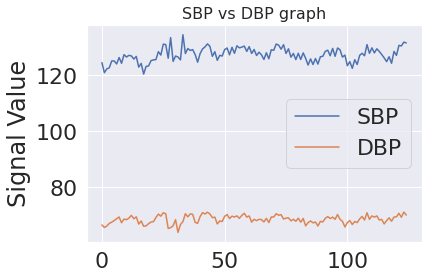

In [106]:
plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(df['SBP'][:125])
plt.plot(df['DBP'][:125])
plt.legend(['SBP', 'DBP'])

## pairplot for all attribute columns

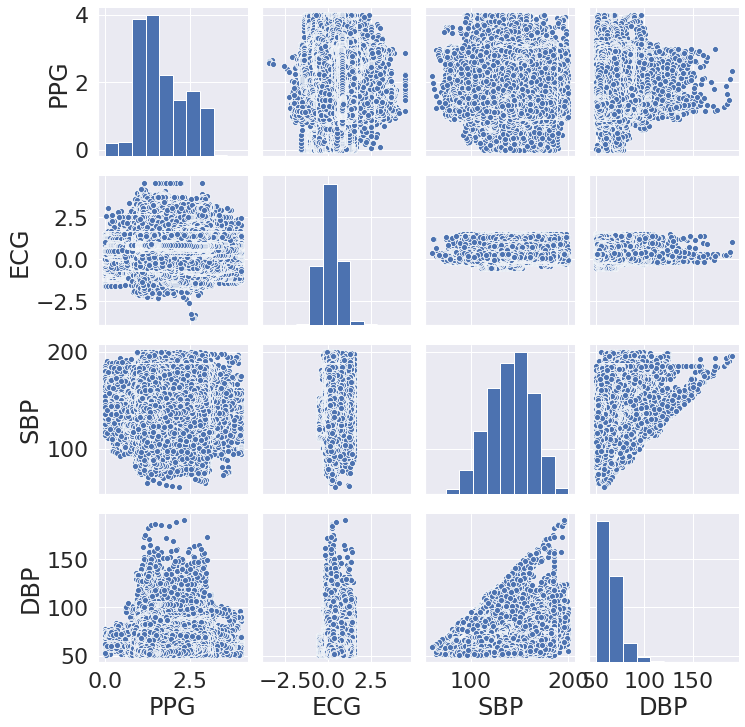

In [107]:
sns.pairplot(df)
plt.show()

## Pair-wise correlation table among all attributes

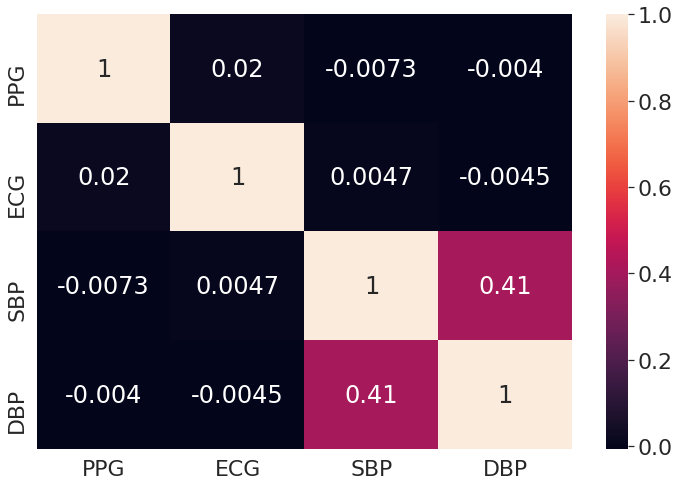

In [108]:
corr = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr,annot = True)
plt.show()

## Calculate PhiK (𝜙k) correlation coefficents of SBP related features

In [1]:
# Load in libraries related to PhiK correlation coefficient calculation and report
import phik
from phik.report import plot_correlation_matrix
from phik import report

### Define SBP related feature columns and calculate their PhiK (𝜙k) correlation matrix

In [2]:
interval_cols_sbp = ['PPG', 'ECG', 'SBP']
phik_overview_sbp = df.phik_matrix(interval_cols=interval_cols_sbp) # calculate the PhiK correlation coefficient matrix
phik_overview_sbp.round(2) # round the results to 2 decimals

NameError: name 'df' is not defined

### Plot the SBP PhiK matrix results as heatmap

In [ ]:
# Plot as heatmap for (visually) analysis convenience
plot_correlation_matrix(phik_overview_sbp.values, 
                        x_labels=phik_overview_sbp.columns, 
                        y_labels=phik_overview_sbp.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"SBP related features correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(8, 5))
plt.tight_layout()

### Significance of the SBP related features PhiK correlations

In [ ]:
significance_overview_sbp = df.significance_matrix(interval_cols=interval_cols_sbp)
plot_correlation_matrix(significance_overview_sbp.fillna(0).values, 
                        x_labels=significance_overview_sbp.columns, 
                        y_labels=significance_overview_sbp.index, 
                        vmin=-5, vmax=5, title="Significance of the SBP features PhiK coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(8, 5))
plt.tight_layout()

### Global correlation of SBP related features

In [ ]:
# The global correlation coefficient is a useful measure expressing the total correlation 
# of one variable to all other variables in the dataset. This gives us an indication 
# of how well one variable can be modeled using the other variables.
global_correlation_sbp, global_labels_sbp = df.global_phik(interval_cols=interval_cols_sbp)

plot_correlation_matrix(global_correlation_sbp, 
                        x_labels=[''], y_labels=global_labels_sbp, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"SBP features $g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

## Calculate PhiK (𝜙k) correlation coefficents of DBP related features

In [ ]:
interval_cols_dbp = ['PPG', 'ECG', 'DBP']
phik_overview_dbp = df_dbp.phik_matrix(interval_cols=interval_cols_dbp) # calculate the PhiK correlation coefficient matrix
phik_overview_dbp.round(2) # round the results to 2 decimals

In [ ]:
# Plot as heatmap for (visually) analysis convenience
plot_correlation_matrix(phik_overview_dbp.values, 
                        x_labels=phik_overview_dbp.columns, 
                        y_labels=phik_overview_dbp.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"DBP related features correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(8, 5))
plt.tight_layout()

In [ ]:
significance_overview_dbp = df_dbp.significance_matrix(interval_cols=interval_cols_dbp)
plot_correlation_matrix(significance_overview_dbp.fillna(0).values, 
                        x_labels=significance_overview_dbp.columns, 
                        y_labels=significance_overview_dbp.index, 
                        vmin=-5, vmax=5, title="Significance of the DBP features PhiK coefficients", 
                        usetex=False, fontsize_factor=1.0, figsize=(8, 5))
plt.tight_layout()

In [ ]:
# The global correlation coefficient is a useful measure expressing the total correlation 
# of one variable to all other variables in the dataset. This gives us an indication 
# of how well one variable can be modeled using the other variables.
global_correlation_dbp, global_labels_dbp = df_dbp.global_phik(interval_cols=interval_cols_dbp)

plot_correlation_matrix(global_correlation_dbp, 
                        x_labels=[''], y_labels=global_labels_dbp, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"DBP features $g_k$",
                        fontsize_factor=1.0)
plt.tight_layout()

## Pandas (EDA) profiling for all features

In [ ]:
!pip install pandas-profiling

In [ ]:
from pandas_profiling import ProfileReport

# Getting the pandas profiling report 
profile = ProfileReport(df) 
profile = df.profile_report(
    correlations={
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": True},
        "cramers": {"calculate": False}, #cramers correlation coefficient is meant for two categorical variables
        "phi_k": {"calculate": True},
    },
)

# to view report created by pandas profile
profile 


Our test and validation errors are within the same range.

Things to try out:

* Predict ecg from ppg instead of bp. (Hint: replace bp with ecg in the cell that has `train_test_split(...)`)
* Experiment with other machine learning models to reduce the error to below `27` for example comment out the `model = LinearRegression()` and the next `model.fit` line and uncomment the commented code to see the improvement